<a href="https://colab.research.google.com/github/Johnogunlola/CIoT-Lab/blob/CIoTH-Lab-1/Pax_Air_Route_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load the dataset (annual route passenger counts 2015-2024)
df = pd.read_csv("Dom Air Pax Route Analysis by Each Reporting Airport 2015 - 2024.csv")
df.head(3)  # preview first three rows


,rundate,this_period,last_period,grp_cd,grp_name,apt1_apt_name,apt2_apt_name,total_pax_tp,total_pax_shd_tp,total_pax_cht_tp,total_pax_lp,total_pax_shd_lp,total_pax_cht_lp,total_pax_pc
0,17/03/2016 11:45,2015,2014,A,London Area Airports,GATWICK,ABERDEEN,163184,163184,0,161816,161816,0,0.845405
1,17/03/2016 11:45,2015,2014,A,London Area Airports,GATWICK,BELFAST CITY (GEORGE BEST),212897,212897,0,277800,277800,0,-23.363211
2,17/03/2016 11:45,2015,2014,A,London Area Airports,GATWICK,BELFAST INTERNATIONAL,470344,470344,0,434305,434214,91,8.298085


In [ ]:
# Combine directional pairs into a unique route identifier (unordered pair of airports)
df['route'] = df.apply(lambda r: tuple(sorted([r['apt1_apt_name'], r['apt2_apt_name']])), axis=1)
unique_routes = df['route'].nunique()
print(f"Number of unique domestic routes: {unique_routes}")


Number of unique domestic routes: 752


In [ ]:
# Identify top 5 busiest routes in 2019 by total passengers
route_year_sum = df.groupby(['route','this_period'])['total_pax_tp'].sum().reset_index()
top5_2019 = (route_year_sum[route_year_sum['this_period']==2019]
             .nlargest(5, 'total_pax_tp'))
print("Top 5 routes in 2019:", top5_2019[['route','total_pax_tp']].values)


Top 5 routes in 2019: [[('EDINBURGH', 'HEATHROW') 2394137]
 [('GLASGOW', 'HEATHROW') 1730211]
 [('EDINBURGH', 'GATWICK') 1463077]
 [('GATWICK', 'JERSEY') 1391229]
 [('ABERDEEN', 'HEATHROW') 1383915]]


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Prepare Heathrow-Edinburgh combined yearly series
route_series = route_year_sum[route_year_sum['route'] == ('EDINBURGH','HEATHROW')].sort_values('this_period')
y = route_series['total_pax_tp'].values  # passenger counts 2015-2024
# Fit an exponential smoothing model with additive trend
model = ExponentialSmoothing(y, trend='add', seasonal=None).fit()
forecast = model.forecast(2)  # predict next 2 years
print("Forecasted passengers for 2025 and 2026:", forecast)


Forecasted passengers for 2025 and 2026: [1426740.20069245 1334692.04333297]


In [ ]:
# Pseudocode for global forecasting with a regression model
all_routes = route_year_sum['route'].unique()
years_of_history = sorted(route_year_sum['this_period'].unique())

features = []
targets = []

# Create a dictionary to easily look up demand for a given route and year
demand = route_year_sum.set_index(['route', 'this_period'])['total_pax_tp'].to_dict()

for route in all_routes:
    for year in years_of_history:
        # Skip the first year as we need the previous year's demand
        if year == years_of_history[0]:
            continue

        # Get demand for the current and previous year, handling missing values
        current_year_demand = demand.get((route, year))
        last_year_demand = demand.get((route, year - 1))

        # Only add if both current and last year demand are available
        if current_year_demand is not None and last_year_demand is not None:
            features.append({
                'route': route,
                'year': year,
                'last_year_demand': last_year_demand,
                # 'volatility': computed_volatility[route], # uncomment and define computed_volatility if needed
                # ... other features ...
            })
            targets.append(current_year_demand)  # predict current year's demand

# Now you can train a regressor (e.g., from scikit-learn) on 'features' and 'targets'
# from sklearn.linear_model import LinearRegression
# model = LinearRegression()
# model.fit(pd.DataFrame(features), targets)

# Predict future year for each route using latest known data
# print("Example of features and targets created:")
# print("Features:", features[:5]) # Print first 5 features as an example
# print("Targets:", targets[:5]) # Print first 5 targets as an example

In [ ]:
"""
Model Evaluation (Yearly):
- Train on 2015–2022
- Predict 2023–2024
- Compute MAPE per route and overall

Models:
  1) Naive (y_hat_t = y_{t-1})
  2) Holt (Exponential Smoothing with additive trend)
  3) Linear trend (OLS on log(passengers) ~ year)

Outputs:
  - forecast_model_leaderboard.csv
  - route_forecast_results_2015_2022_train_2023_2024_test.csv
"""

'\nModel Evaluation (Yearly):\n- Train on 2015–2022\n- Predict 2023–2024\n- Compute MAPE per route and overall\n\nModels:\n  1) Naive (y_hat_t = y_{t-1})\n  2) Holt (Exponential Smoothing with additive trend)\n  3) Linear trend (OLS on log(passengers) ~ year)\n\nOutputs:\n  - forecast_model_leaderboard.csv\n  - route_forecast_results_2015_2022_train_2023_2024_test.csv\n'

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import numpy as np
import pandas as pd

# Optional: install if missing in your env
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm

In [ ]:
# ---------------------------
# Config
# ---------------------------
DATA_PATH = "Dom Air Pax Route Analysis by Each Reporting Airport 2015 - 2024.csv"
OUT_DIR   = "./"

TRAIN_YEARS = list(range(2015, 2023))  # 2015..2022
TEST_YEARS  = [2023, 2024]
ALL_YEARS   = list(range(2015, 2025))  # 2015..2024


In [ ]:
# ---------------------------
# Utilities
# ---------------------------
def route_key(a: str, b: str) -> str:
    """Make a stable, unordered route string 'A — B' (sorted endpoints)."""
    a = str(a).strip()
    b = str(b).strip()
    ends = sorted([a, b])
    return f"{ends[0]} — {ends[1]}"

def mape(pred, actual) -> float:
    """Mean Absolute Percentage Error for a single value (safe)."""
    if actual is None or (isinstance(actual, float) and np.isnan(actual)) or actual <= 0:
        return np.nan
    if pred is None or (isinstance(pred, float) and np.isnan(pred)):
        return np.nan
    return abs(pred - actual) / actual * 100.0

In [ ]:
# ---------------------------
# Load & aggregate to route-year
# ---------------------------
def load_and_aggregate(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Basic sanity on expected columns (your file already has these names)
    needed = ["apt1_apt_name", "apt2_apt_name", "this_period", "total_pax_tp"]
    # Try to map alternates if needed
    alt_map = {
        "airport_1_name": "apt1_apt_name",
        "airport_2_name": "apt2_apt_name",
        "year": "this_period",
        "total_pax_this_period": "total_pax_tp",
    }
    for src, dst in alt_map.items():
        if src in df.columns and dst not in df.columns:
            df[dst] = df[src]
    for c in needed:
        if c not in df.columns:
            raise ValueError(f"Missing required column: {c}")

    # Build route key and numeric fields
    df["route"] = df.apply(
        lambda r: route_key(r["apt1_apt_name"], r["apt2_apt_name"]),
        axis=1
    )
    df["year"] = pd.to_numeric(df["this_period"], errors="coerce")
    df["pax"]  = pd.to_numeric(df["total_pax_tp"], errors="coerce")

    # Aggregate both directions to route-year totals
    agg = (df.groupby(["route", "year"], as_index=False)["pax"]
             .sum()
             .sort_values(["route", "year"]))
    # Limit to 2015..2024
    agg = agg[(agg["year"] >= 2015) & (agg["year"] <= 2024)].copy()
    return agg


In [ ]:
# ---------------------------
# Forecasting models (per route)
# ---------------------------
def fc_naive(series: pd.Series) -> dict:
    """Naive: ŷ_2023 = y_2022; ŷ_2024 = y_2023."""
    return {
        2023: series.get(2022, np.nan),
        2024: series.get(2023, np.nan),
    }

def fc_holt(series: pd.Series) -> dict:
    """Holt's ES with additive trend; fallback to naive if too short."""
    train = series.loc[TRAIN_YEARS].dropna()
    if len(train) < 4:
        return fc_naive(series)
    try:
        model = ExponentialSmoothing(train.values, trend="add", seasonal=None)
        fit   = model.fit(optimized=True, use_brute=True)
        fc    = fit.forecast(len(TEST_YEARS))
        out = {
            2023: max(0.0, float(fc[0])),
            2024: max(0.0, float(fc[1])) if len(fc) > 1 else max(0.0, float(fc[0])),
        }
        return out
    except Exception:
        return fc_naive(series)

def fc_linear(series: pd.Series) -> dict:
    """Linear trend on log(pax+1) ~ year; fallback to naive if too short."""
    train = series.loc[TRAIN_YEARS].dropna()
    if len(train) < 3:
        return fc_naive(series)
    try:
        y = np.log(train.values + 1.0)
        X = np.column_stack([np.ones(len(train)), np.array(train.index, dtype=float)])
        mdl = sm.OLS(y, X).fit()
        preds = {}
        for yr in TEST_YEARS:
            Xf = np.array([[1.0, float(yr)]])
            yh = mdl.predict(Xf)[0]
            preds[yr] = max(0.0, float(np.exp(yh) - 1.0))
        return preds
    except Exception:
        return fc_naive(series)

In [ ]:
# ---------------------------
# Evaluation
# ---------------------------
def evaluate_models(agg: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    # Pivot to matrix for convenience
    routes = sorted(agg["route"].unique().tolist())
    mat = (agg.pivot_table(index="route", columns="year", values="pax", aggfunc="sum")
              .reindex(index=routes, columns=ALL_YEARS))

    records = []
    for route in routes:
        series = mat.loc[route]
        act_2023 = series.get(2023, np.nan)
        act_2024 = series.get(2024, np.nan)

        model_preds = {
            "Naive":  fc_naive(series),
            "Holt":   fc_holt(series),
            "Linear": fc_linear(series),
        }

        for model_name, preds in model_preds.items():
            p2023 = preds.get(2023, np.nan)
            p2024 = preds.get(2024, np.nan)

            rec = {
                "route": route,
                "model": model_name,
                "pred_2023": p2023,
                "actual_2023": act_2023,
                "mape_2023": mape(p2023, act_2023),
                "pred_2024": p2024,
                "actual_2024": act_2024,
                "mape_2024": mape(p2024, act_2024),
            }
            rec["mape_avg"] = np.nanmean([rec["mape_2023"], rec["mape_2024"]])
            records.append(rec)

    results = pd.DataFrame.from_records(records)

    # Overall unweighted average MAPE per model
    overall = (results.groupby("model")["mape_avg"]
               .mean()
               .reset_index()
               .rename(columns={"mape_avg": "overall_mape_avg_%"})
               .sort_values("overall_mape_avg_%"))

    # Passenger-weighted MAPE across 2023 & 2024
    def weighted_mape(group: pd.DataFrame) -> float:
        rows = []
        for _, r in group.iterrows():
            if pd.notna(r["actual_2023"]) and r["actual_2023"] > 0 and pd.notna(r["pred_2023"]):
                rows.append((abs(r["pred_2023"] - r["actual_2023"]), r["actual_2023"]))
            if pd.notna(r["actual_2024"]) and r["actual_2024"] > 0 and pd.notna(r["pred_2024"]):
                rows.append((abs(r["pred_2024"] - r["actual_2024"]), r["actual_2024"]))
        if not rows:
            return np.nan
        err = sum(e for e, a in rows)
        denom = sum(a for e, a in rows)
        return (err / denom) * 100.0

    weighted = (results.groupby("model")
                .apply(weighted_mape)
                .reset_index(name="overall_weighted_mape_%")
                .sort_values("overall_weighted_mape_%"))

    leaderboard = overall.merge(weighted, on="model")

    return results, leaderboard

In [ ]:
# ---------------------------
# Main
# ---------------------------
def main(data_path: str = DATA_PATH, out_dir: str = OUT_DIR):
    os.makedirs(out_dir, exist_ok=True)
    agg = load_and_aggregate(data_path)
    results, leaderboard = evaluate_models(agg)

    # Print quick summary
    print("\n=== Overall Model Leaderboard (lower is better) ===")
    print(leaderboard.to_string(index=False))
    print(f"\nSaved per-route results to: {results_path}")
    print(f"Saved leaderboard to:       {leaderboard_path}")


In [ ]:
"""
Visualisations for UK Domestic Air Route Analysis:
- Exploratory plots (annual totals, busiest routes, selected route panels)
- SSR risk plots (Top-K routes by SSR)
- Forecast evaluation plots (actual vs forecast; MAPE leaderboards; error distributions)

Assumptions:
- Data file: "Dom Air Pax Route Analysis by Each Reporting Airport 2015 - 2024.csv"
- Optional results (if already generated by evaluation script):
    - "forecast_model_leaderboard.csv"
    - "route_forecast_results_2015_2022_train_2023_2024_test.csv"
If these don't exist, this script will compute them.

Outputs:
- Figures saved under ./figures/
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm

# --------------------------
# CONFIG
# --------------------------
DATA_PATH = "Dom Air Pax Route Analysis by Each Reporting Airport 2015 - 2024.csv"
LEADERBOARD_CSV = "forecast_model_leaderboard.csv"
RESULTS_CSV = "route_forecast_results_2015_2022_train_2023_2024_test.csv"
FIGDIR = Path("figures")
FIGDIR.mkdir(exist_ok=True)

TRAIN_YEARS = list(range(2015, 2023))  # 2015..2022
TEST_YEARS = [2023, 2024]
ALL_YEARS = list(range(2015, 2025))   # 2015..2024

In [ ]:
# --------------------------
# HELPERS
# --------------------------
def route_key(a: str, b: str) -> str:
    a = str(a).strip(); b = str(b).strip()
    ends = sorted([a, b])
    return f"{ends[0]} — {ends[1]}"

def mape(pred, actual) -> float:
    if actual is None or (isinstance(actual, float) and np.isnan(actual)) or actual <= 0:
        return np.nan
    if pred is None or (isinstance(pred, float) and np.isnan(pred)):
        return np.nan
    return abs(pred - actual) / actual * 100.0

def load_and_aggregate(data_path: str) -> pd.DataFrame:
    df = pd.read_csv(data_path)
    # Map alternates if needed
    alt_map = {
        "airport_1_name": "apt1_apt_name",
        "airport_2_name": "apt2_apt_name",
        "year": "this_period",
        "total_pax_this_period": "total_pax_tp",
    }
    for src, dst in alt_map.items():
        if src in df.columns and dst not in df.columns:
            df[dst] = df[src]
    needed = ["apt1_apt_name", "apt2_apt_name", "this_period", "total_pax_tp"]
    for c in needed:
        if c not in df.columns:
            raise ValueError(f"Missing required column: {c}")

    df["route"] = df.apply(lambda r: route_key(r["apt1_apt_name"], r["apt2_apt_name"]), axis=1)
    df["year"] = pd.to_numeric(df["this_period"], errors="coerce")
    df["pax"] = pd.to_numeric(df["total_pax_tp"], errors="coerce")

    agg = (df.groupby(["route", "year"], as_index=False)["pax"]
             .sum()
             .sort_values(["route", "year"]))
    agg = agg[(agg["year"] >= 2015) & (agg["year"] <= 2024)].copy()
    return agg


In [ ]:
# --------------------------
# HELPERS
# --------------------------
def route_key(a: str, b: str) -> str:
    a = str(a).strip(); b = str(b).strip()
    ends = sorted([a, b])
    return f"{ends[0]} — {ends[1]}"

def mape(pred, actual) -> float:
    if actual is None or (isinstance(actual, float) and np.isnan(actual)) or actual <= 0:
        return np.nan
    if pred is None or (isinstance(pred, float) and np.isnan(pred)):
        return np.nan
    return abs(pred - actual) / actual * 100.0

def load_and_aggregate(data_path: str) -> pd.DataFrame:
    df = pd.read_csv(data_path)
    # Map alternates if needed
    alt_map = {
        "airport_1_name": "apt1_apt_name",
        "airport_2_name": "apt2_apt_name",
        "year": "this_period",
        "total_pax_this_period": "total_pax_tp",
    }
    for src, dst in alt_map.items():
        if src in df.columns and dst not in df.columns:
            df[dst] = df[src]
    needed = ["apt1_apt_name", "apt2_apt_name", "this_period", "total_pax_tp"]
    for c in needed:
        if c not in df.columns:
            raise ValueError(f"Missing required column: {c}")

    df["route"] = df.apply(lambda r: route_key(r["apt1_apt_name"], r["apt2_apt_name"]), axis=1)
    df["year"] = pd.to_numeric(df["this_period"], errors="coerce")
    df["pax"] = pd.to_numeric(df["total_pax_tp"], errors="coerce")

    agg = (df.groupby(["route", "year"], as_index=False)["pax"]
             .sum()
             .sort_values(["route", "year"]))
    agg = agg[(agg["year"] >= 2015) & (agg["year"] <= 2024)].copy()
    return agg
# ------------- forecasting (for evaluation if needed) -------------
def fc_naive(series: pd.Series) -> dict:
    return {2023: series.get(2022, np.nan), 2024: series.get(2023, np.nan)}

def fc_holt(series: pd.Series) -> dict:
    train = series.loc[TRAIN_YEARS].dropna()
    if len(train) < 4:
        return fc_naive(series)
    try:
        model = ExponentialSmoothing(train.values, trend="add", seasonal=None)
        fit = model.fit(optimized=True, use_brute=True)
        fc = fit.forecast(len(TEST_YEARS))
        return {2023: max(0.0, float(fc[0])),
                2024: max(0.0, float(fc[1])) if len(fc) > 1 else max(0.0, float(fc[0]))}
    except Exception:
        return fc_naive(series)

def fc_linear(series: pd.Series) -> dict:
    train = series.loc[TRAIN_YEARS].dropna()
    if len(train) < 3:
        return fc_naive(series)
    try:
        y = np.log(train.values + 1.0)
        X = np.column_stack([np.ones(len(train)), np.array(train.index, dtype=float)])
        mdl = sm.OLS(y, X).fit()
        preds = {}
        for yr in TEST_YEARS:
            Xf = np.array([[1.0, float(yr)]])
            yh = mdl.predict(Xf)[0]
            preds[yr] = max(0.0, float(np.exp(yh) - 1.0))
        return preds
    except Exception:
        return fc_naive(series)

def ensure_eval_results(agg: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Return (results_df, leaderboard_df). Load from CSV if exists; else compute."""
    if Path(RESULTS_CSV).exists() and Path(LEADERBOARD_CSV).exists():
        results = pd.read_csv(RESULTS_CSV)
        leaderboard = pd.read_csv(LEADERBOARD_CSV)
        return results, leaderboard

    routes = sorted(agg["route"].unique().tolist())
    mat = (agg.pivot_table(index="route", columns="year", values="pax", aggfunc="sum")
              .reindex(index=routes, columns=ALL_YEARS))
    records = []
    for route in routes:
        s = mat.loc[route]
        act_2023, act_2024 = s.get(2023, np.nan), s.get(2024, np.nan)
        model_preds = {"Naive": fc_naive(s), "Holt": fc_holt(s), "Linear": fc_linear(s)}
        for name, p in model_preds.items():
            rec = {
                "route": route,
                "model": name,
                "pred_2023": p.get(2023, np.nan),
                "actual_2023": act_2023,
                "mape_2023": mape(p.get(2023, np.nan), act_2023),
                "pred_2024": p.get(2024, np.nan),
                "actual_2024": act_2024,
                "mape_2024": mape(p.get(2024, np.nan), act_2024),
            }
            rec["mape_avg"] = np.nanmean([rec["mape_2023"], rec["mape_2024"]])
            records.append(rec)
    results = pd.DataFrame.from_records(records)

    def weighted_mape(dfm):
        rows = []
        for _, r in dfm.iterrows():
            if pd.notna(r["actual_2023"]) and r["actual_2023"] > 0 and pd.notna(r["pred_2023"]):
                rows.append((abs(r["pred_2023"] - r["actual_2023"]), r["actual_2023"]))
            if pd.notna(r["actual_2024"]) and r["actual_2024"] > 0 and pd.notna(r["pred_2024"]):
                rows.append((abs(r["pred_2024"] - r["actual_2024"]), r["actual_2024"]))
        if not rows:
            return np.nan
        err = sum(e for e, a in rows)
        denom = sum(a for e, a in rows)
        return (err / denom) * 100.0

    overall = (results.groupby("model")["mape_avg"]
               .mean()
               .reset_index()
               .rename(columns={"mape_avg":"overall_mape_avg_%"}))
    weighted = (results.groupby("model").apply(weighted_mape)
                .reset_index(name="overall_weighted_mape_%"))
    leaderboard = overall.merge(weighted, on="model")

    results.to_csv(RESULTS_CSV, index=False)
    leaderboard.to_csv(LEADERBOARD_CSV, index=False)
    return results, leaderboard

In [ ]:
# --------------------------
# EDA VISUALS
# --------------------------
def plot_total_pax_by_year(agg: pd.DataFrame):
    totals = agg.groupby("year")["pax"].sum()
    plt.figure(figsize=(8,4))
    plt.plot(totals.index, totals.values, marker="o")
    plt.title("Total UK Domestic Passengers by Year")
    plt.xlabel("Year")
    plt.ylabel("Passengers")
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.savefig(FIGDIR / "eda_total_passengers_by_year.png", dpi=150)

def plot_top_routes_year(agg: pd.DataFrame, year: int = 2019, top_k: int = 10):
    yr = (agg[agg["year"] == year]
          .sort_values("pax", ascending=False)
          .head(top_k))
    plt.figure(figsize=(9,5))
    plt.barh(yr["route"][::-1], yr["pax"][::-1])
    plt.title(f"Top {top_k} Routes by Passengers in {year}")
    plt.xlabel("Passengers")
    plt.tight_layout()
    plt.savefig(FIGDIR / f"eda_top{top_k}_routes_{year}.png", dpi=150)

def plot_selected_route_panels(agg: pd.DataFrame, routes: list[str]):
    mat = agg.pivot_table(index="route", columns="year", values="pax", aggfunc="sum")
    n = len(routes)
    rows = min(n, 4)
    cols = int(np.ceil(n / rows))
    plt.figure(figsize=(4*cols, 3*rows))
    for i, r in enumerate(routes, 1):
        if r not in mat.index:
            continue
        s = mat.loc[r].dropna()
        plt.subplot(rows, cols, i)
        plt.plot(s.index, s.values, marker="o")
        plt.title(r)
        plt.xlabel("Year"); plt.ylabel("Passengers")
        plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.savefig(FIGDIR / "eda_selected_route_panels.png", dpi=150)

In [ ]:
# --------------------------
# SSR (volatility + imbalance) VISUALS
# --------------------------
def compute_ssr(agg: pd.DataFrame, raw_df: pd.DataFrame) -> pd.DataFrame:
    # Volatility per route (coef. of variation across 2015–2024)
    vol = (agg.groupby("route")["pax"]
             .agg(lambda x: np.nanstd(x) / np.nanmean(x) if np.nanmean(x) > 0 else np.nan)
             .rename("cv"))
    # Directional imbalance: |A->B - B->A| / total over entire period
    # Build directional sums from raw
    df = raw_df.copy()
    df["A"] = df["apt1_apt_name"].astype(str).str.strip()
    df["B"] = df["apt2_apt_name"].astype(str).str.strip()
    df["route_u"] = df.apply(lambda r: tuple(sorted([r["A"], r["B"]])), axis=1)
    df["year"] = pd.to_numeric(df["this_period"], errors="coerce")
    df["pax"]  = pd.to_numeric(df["total_pax_tp"], errors="coerce")
    dir_sum = df.groupby(["route_u","A","B"], as_index=False)["pax"].sum()
    # Convert to long with consistent pair id
    # For each unordered route, compute total A->B and B->A over the whole period
    pair_totals = {}
    for _, row in dir_sum.iterrows():
        ru = row["route_u"]; A = row["A"]; B = row["B"]; px = row["pax"]
        pair_totals.setdefault(ru, {"AB":0.0, "BA":0.0, "names":ru})
        if tuple(sorted([A,B])) != ru:
            continue
        # orientation: ru is sorted; determine if current row is ru[0] -> ru[1]
        if (A == ru[0]) and (B == ru[1]):
            pair_totals[ru]["AB"] += float(px if pd.notna(px) else 0.0)
        else:
            pair_totals[ru]["BA"] += float(px if pd.notna(px) else 0.0)
    rows = []
    for ru, val in pair_totals.items():
        ab = val["AB"]; ba = val["BA"]
        tot = ab + ba
        imb = np.nan
        if tot > 0:
            imb = abs(ab - ba) / tot
        rk = f"{ru[0]} — {ru[1]}"
        rows.append({"route": rk, "imbalance": imb})
    imb_df = pd.DataFrame(rows).set_index("route")

    ssr = pd.concat([vol, imb_df], axis=1)
    ssr["SSR"] = ssr["cv"].fillna(0) + ssr["imbalance"].fillna(0)
    return ssr.reset_index()

def plot_topk_ssr(ssr_df: pd.DataFrame, top_k: int = 15):
    top = ssr_df.sort_values("SSR", ascending=False).head(top_k)
    plt.figure(figsize=(10,6))
    plt.barh(top["route"][::-1], top["SSR"][::-1])
    plt.title(f"Top {top_k} Routes by Safety Strain Risk (SSR)")
    plt.xlabel("SSR = volatility (CV) + directional imbalance")
    plt.tight_layout()
    plt.savefig(FIGDIR / f"ssr_top{top_k}.png", dpi=150)

In [ ]:
# --------------------------
# FORECAST EVALUATION VISUALS
# --------------------------
def plot_leaderboard(leaderboard: pd.DataFrame):
    dfp = leaderboard.copy()
    plt.figure(figsize=(6,4))
    x = np.arange(len(dfp["model"]))
    w = 0.35
    plt.bar(x - w/2, dfp["overall_mape_avg_%"], width=w, label="Unweighted")
    plt.bar(x + w/2, dfp["overall_weighted_mape_%"], width=w, label="Weighted by pax")
    plt.xticks(x, dfp["model"])
    plt.title("Overall Forecast Error (MAPE, 2023–2024)")
    plt.ylabel("MAPE (%)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIGDIR / "eval_leaderboard_mape.png", dpi=150)

def plot_error_distributions(results: pd.DataFrame):
    # Distributions of route-level average MAPE for each model
    plt.figure(figsize=(8,5))
    for model in sorted(results["model"].unique()):
        m = results[results["model"]==model]["mape_avg"].dropna()
        # Kernel density can be noisy on short sets; use hist
        plt.hist(m.values, bins=30, alpha=0.5, label=model)
    plt.title("Distribution of Route-level Average MAPE (2023–2024)")
    plt.xlabel("MAPE (%)")
    plt.ylabel("Number of routes")
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIGDIR / "eval_mape_distributions.png", dpi=150)

def plot_actual_vs_forecast(results: pd.DataFrame, agg: pd.DataFrame, route: str):
    """Line plot with train (2015–2022 actual), test (2023–2024 actual) and model forecasts."""
    mat = agg.pivot_table(index="route", columns="year", values="pax", aggfunc="sum")
    if route not in mat.index:
        return
    s = mat.loc[route].copy()
    # Gather forecasts for each model
    preds = (results[results["route"]==route]
             .set_index("model")[["pred_2023","pred_2024"]])
    plt.figure(figsize=(8,4))
    # Actual series
    plt.plot(s.loc[2015:2022].index, s.loc[2015:2022].values, marker="o", label="Actual (Train)")
    plt.plot([2023, 2024], [s.get(2023, np.nan), s.get(2024, np.nan)],
             marker="o", linestyle="--", label="Actual (Test)")
    # Forecasts
    for model in preds.index:
        plt.plot([2023, 2024], preds.loc[model].values, marker="o", linestyle=":", label=f"{model} Forecast")
    plt.title(route)
    plt.xlabel("Year"); plt.ylabel("Passengers")
    plt.grid(True, linestyle=":")
    plt.legend()
    safe_name = route.replace("/", "-").replace("—", "-").replace(" ", "_")
    plt.tight_layout()
    plt.savefig(FIGDIR / f"eval_actual_vs_forecast_{safe_name}.png", dpi=150)

def plot_model_winners_map(results: pd.DataFrame, top_n: int = 30):
    """Bar chart: for top_n heaviest routes (by 2024 pax), show which model had the lowest MAPE."""
    # Identify winner per route by mape_avg
    winners = (results.loc[:, ["route","model","mape_avg"]]
               .sort_values(["route","mape_avg"])
               .dropna(subset=["mape_avg"])
               .groupby("route")
               .first()
               .reset_index())
    # Heaviest routes by 2024 pax (from results join agg)
    # Build 2024 pax per route
    df = pd.read_csv(DATA_PATH)
    df["route"] = df.apply(lambda r: route_key(r["apt1_apt_name"], r["apt2_apt_name"]), axis=1)
    df["year"] = pd.to_numeric(df["this_period"], errors="coerce")
    df["pax"] = pd.to_numeric(df["total_pax_tp"], errors="coerce")
    pax24 = (df[df["year"]==2024].groupby("route")["pax"].sum().reset_index(name="pax_2024"))
    winners = winners.merge(pax24, on="route", how="left").fillna({"pax_2024":0})
    winners = winners.sort_values("pax_2024", ascending=False).head(top_n)

    plt.figure(figsize=(10,6))
    plt.barh(winners["route"][::-1], winners["pax_2024"][::-1])
    for i, (model, y) in enumerate(zip(winners["model"][::-1], winners["pax_2024"][::-1])):
        plt.text(y, i, f" {model}", va="center")
    plt.title(f"Model Winners on Top {top_n} Routes by 2024 Passengers")
    plt.xlabel("Passengers in 2024")
    plt.tight_layout()
    plt.savefig(FIGDIR / "eval_model_winners_top_routes.png", dpi=150)

Saved figures to: /content/figures


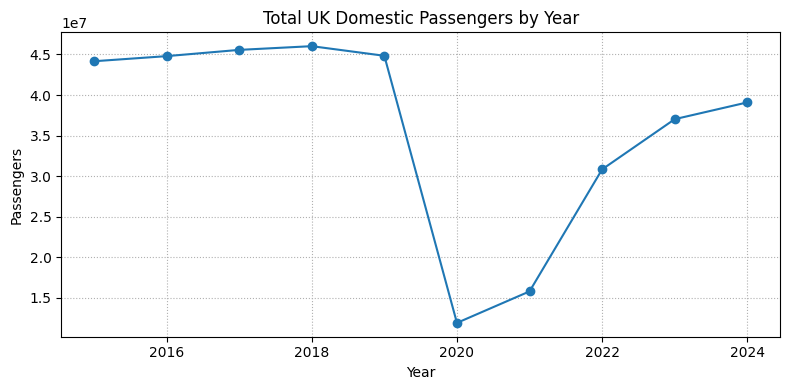

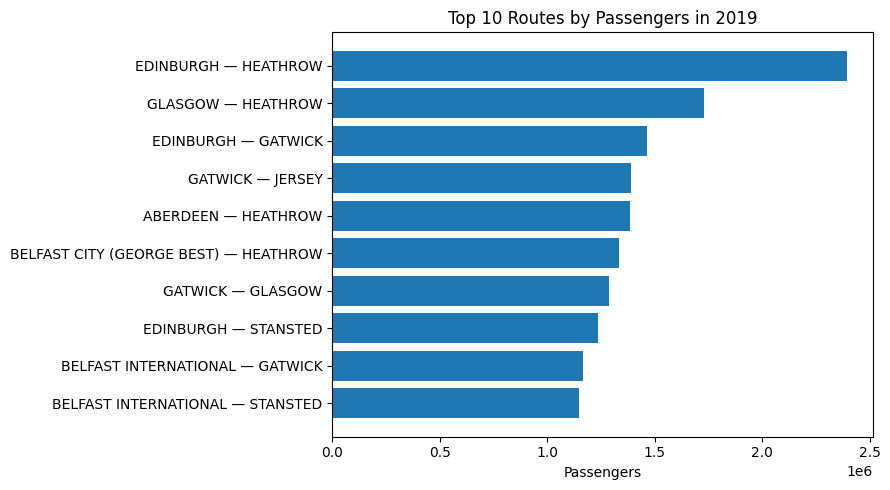

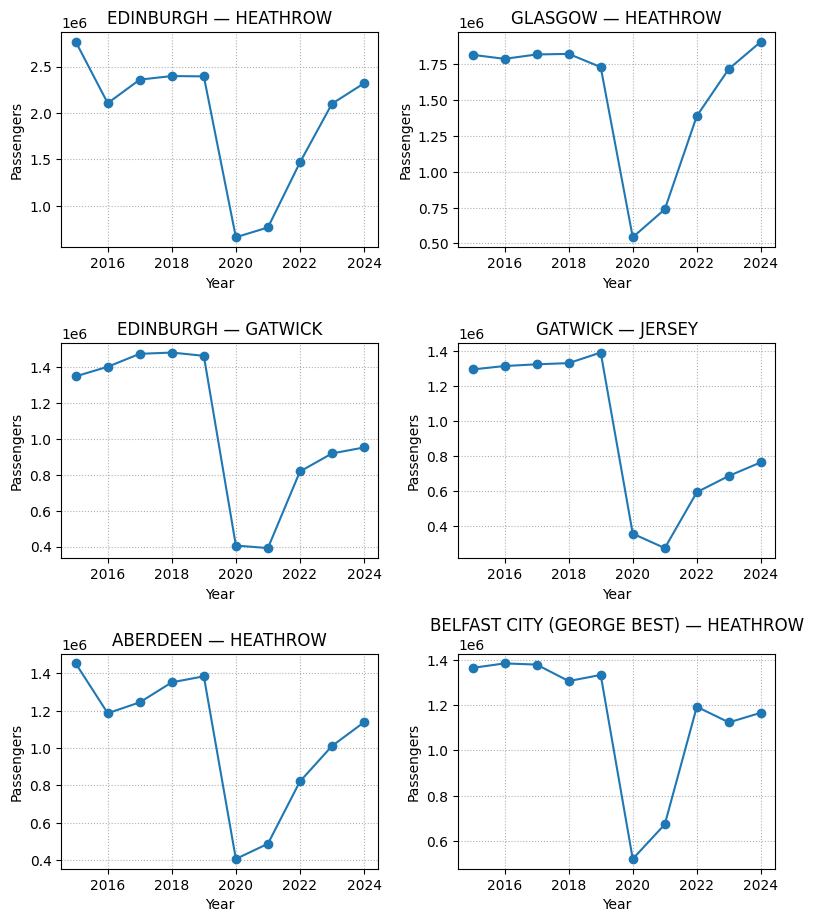

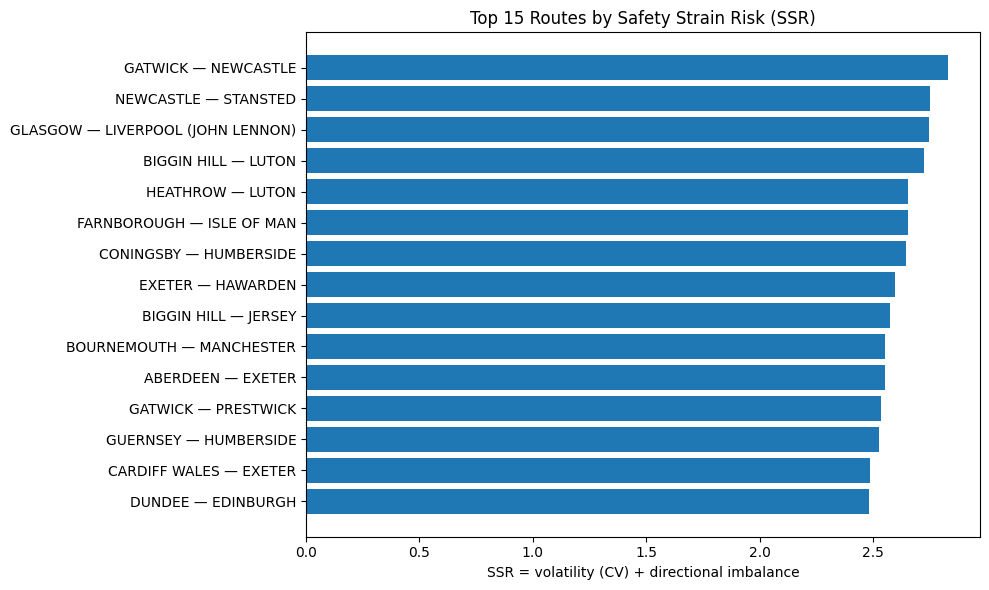

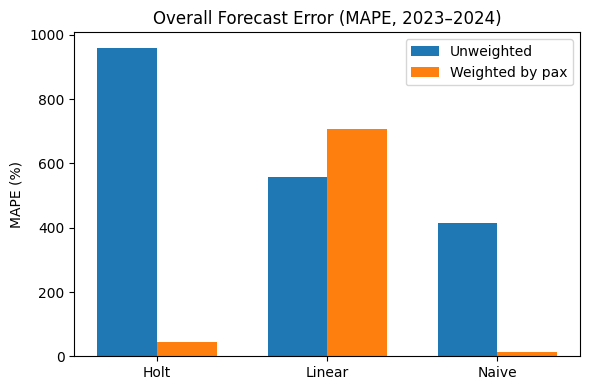

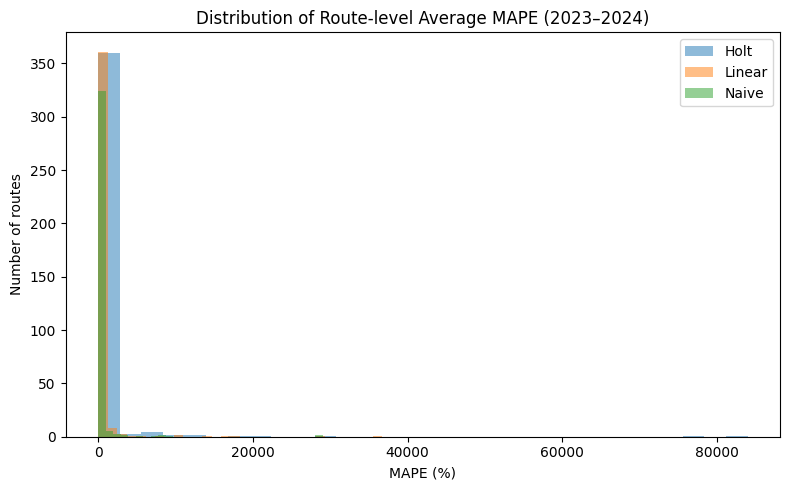

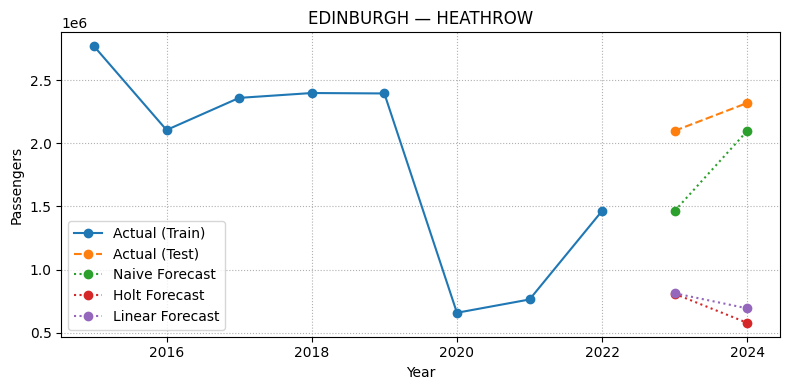

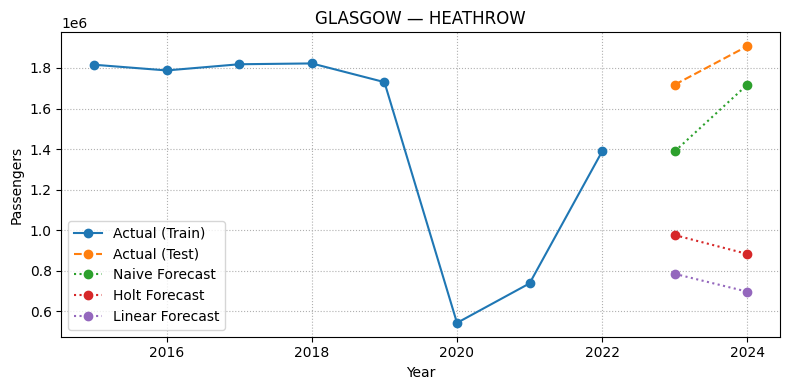

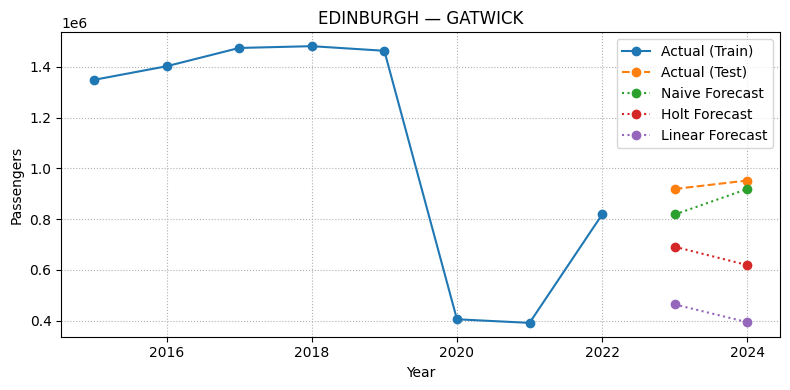

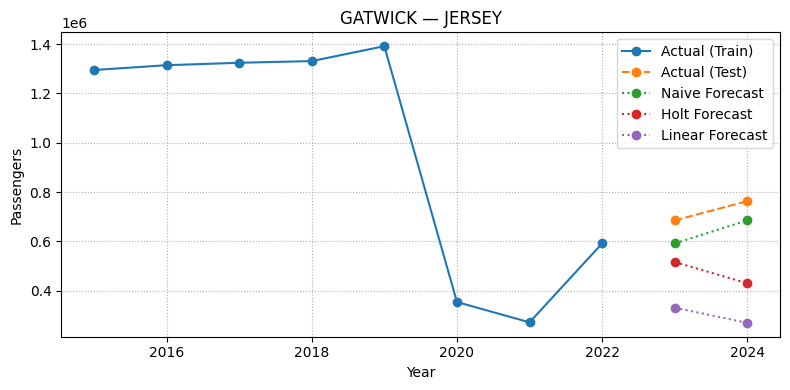

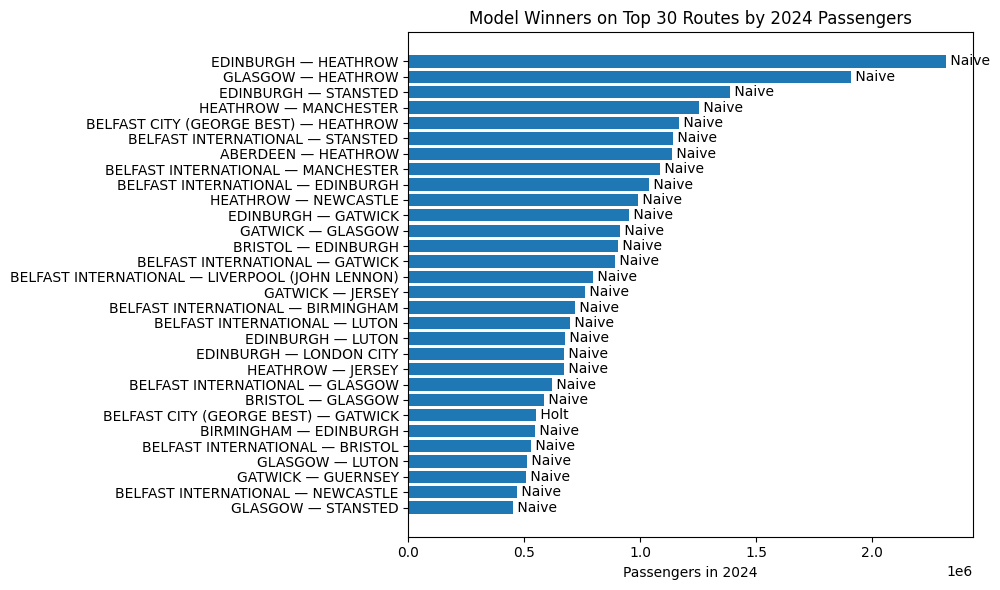

In [ ]:
# --------------------------
# MAIN
# --------------------------
if __name__ == "__main__":
    # Load
    agg = load_and_aggregate(DATA_PATH)
    raw_df = pd.read_csv(DATA_PATH)

    # EDA figs
    plot_total_pax_by_year(agg)
    plot_top_routes_year(agg, year=2019, top_k=10)
    # Pick a few representative routes for panels
    busiest_2019 = (agg[agg["year"]==2019]
                    .sort_values("pax", ascending=False)
                    .head(6)["route"].tolist())
    plot_selected_route_panels(agg, busiest_2019)

    # SSR figs
    ssr_df = compute_ssr(agg, raw_df)
    plot_topk_ssr(ssr_df, top_k=15)

    # Evaluation figs
    results, leaderboard = ensure_eval_results(agg)
    plot_leaderboard(leaderboard)
    plot_error_distributions(results)

    # Actual vs forecast for a few heavy routes
    for r in busiest_2019[:4]:
        plot_actual_vs_forecast(results, agg, r)

    # Who wins per route among top-traffic routes
    plot_model_winners_map(results, top_n=30)

    print(f"Saved figures to: {FIGDIR.resolve()}")

In [ ]:
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm


In [ ]:
# ---------------------------
# Config
# ---------------------------
DATA_PATH = "Dom Air Pax Route Analysis by Each Reporting Airport 2015 - 2024.csv"
OUTDIR = Path("outputs"); OUTDIR.mkdir(exist_ok=True)
FIGDIR = Path("figures"); FIGDIR.mkdir(exist_ok=True)

TRAIN_YEARS = list(range(2015, 2023))  # 2015..2022
TEST_YEARS  = [2023, 2024]
ALL_YEARS   = list(range(2015, 2025))

In [ ]:
# ---------------------------
# Helpers
# ---------------------------
def route_key(a: str, b: str) -> str:
    a = str(a).strip(); b = str(b).strip()
    ends = sorted([a, b])
    return f"{ends[0]} — {ends[1]}"

def mae(pred, actual):
    if pred is None or actual is None or np.isnan(pred) or np.isnan(actual):
        return np.nan
    return abs(pred - actual)

def rmse(preds: np.ndarray, actuals: np.ndarray):
    mask = (~np.isnan(preds)) & (~np.isnan(actuals))
    if mask.sum() == 0:
        return np.nan
    return float(np.sqrt(np.mean((preds[mask] - actuals[mask])**2)))

def mape(pred, actual):
    if actual is None or (isinstance(actual, float) and np.isnan(actual)) or actual <= 0:
        return np.nan
    if pred is None or (isinstance(pred, float) and np.isnan(pred)):
        return np.nan
    return abs(pred - actual) / actual * 100.0

def smape(pred, actual):
    # symmetric MAPE (%)
    if pred is None or actual is None or np.isnan(pred) or np.isnan(actual):
        return np.nan
    denom = (abs(pred) + abs(actual)) / 2.0
    if denom == 0:
        return np.nan
    return (abs(pred - actual) / denom) * 100.0

def load_and_aggregate(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    # Flexible mapping if alt names exist
    alt_map = {
        "airport_1_name": "apt1_apt_name",
        "airport_2_name": "apt2_apt_name",
        "year": "this_period",
        "total_pax_this_period": "total_pax_tp",
    }
    for src, dst in alt_map.items():
        if src in df.columns and dst not in df.columns:
            df[dst] = df[src]

    needed = ["apt1_apt_name", "apt2_apt_name", "this_period", "total_pax_tp"]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise ValueError(f"Missing expected columns: {missing}")

    df["route"] = df.apply(lambda r: route_key(r["apt1_apt_name"], r["apt2_apt_name"]), axis=1)
    df["year"]  = pd.to_numeric(df["this_period"], errors="coerce")
    df["pax"]   = pd.to_numeric(df["total_pax_tp"], errors="coerce")

    agg = (df.groupby(["route","year"], as_index=False)["pax"]
             .sum()
             .sort_values(["route","year"]))
    agg = agg[(agg["year"]>=2015) & (agg["year"]<=2024)].copy()
    return agg

In [ ]:
# ---------------------------
# Forecast models (per route)
# ---------------------------
def fc_naive(series: pd.Series) -> dict:
    return {
        2023: series.get(2022, np.nan),
        2024: series.get(2023, np.nan),
    }

def fc_holt(series: pd.Series) -> dict:
    train = series.loc[TRAIN_YEARS].dropna()
    if len(train) < 4:
        return fc_naive(series)
    try:
        model = ExponentialSmoothing(train.values, trend="add", seasonal=None)
        fit   = model.fit(optimized=True, use_brute=True)
        fc    = fit.forecast(len(TEST_YEARS))
        return {
            2023: max(0.0, float(fc[0])),
            2024: max(0.0, float(fc[1])) if len(fc)>1 else max(0.0, float(fc[0]))
        }
    except Exception:
        return fc_naive(series)

def fc_linear(series: pd.Series) -> dict:
    train = series.loc[TRAIN_YEARS].dropna()
    if len(train) < 3:
        return fc_naive(series)
    try:
        y = np.log(train.values + 1.0)
        X = np.column_stack([np.ones(len(train)), np.array(train.index, dtype=float)])
        mdl = sm.OLS(y, X).fit()
        out = {}
        for yr in TEST_YEARS:
            Xf = np.array([[1.0, float(yr)]])
            yh = mdl.predict(Xf)[0]
            out[yr] = max(0.0, float(np.exp(yh) - 1.0))
        return out
    except Exception:
        return fc_naive(series)

In [ ]:
# ---------------------------
# Evaluation
# ---------------------------
def evaluate_models(agg: pd.DataFrame) -> pd.DataFrame:
    routes = sorted(agg["route"].unique().tolist())
    mat = (agg.pivot_table(index="route", columns="year", values="pax", aggfunc="sum")
              .reindex(index=routes, columns=ALL_YEARS))

    records = []
    for route in routes:
        s = mat.loc[route]
        act_2023 = s.get(2023, np.nan)
        act_2024 = s.get(2024, np.nan)

        model_preds = {
            "Naive":  fc_naive(s),
            "Holt":   fc_holt(s),
            "Linear": fc_linear(s),
        }

        for model_name, preds in model_preds.items():
            p2023 = preds.get(2023, np.nan)
            p2024 = preds.get(2024, np.nan)

            rec = {
                "route": route,
                "model": model_name,
                "pred_2023": p2023,
                "actual_2023": act_2023,
                "mae_2023": mae(p2023, act_2023),
                "rmse_2023": np.nan,  # will compute globally
                "mape_2023": mape(p2023, act_2023),
                "smape_2023": smape(p2023, act_2023),
                "pred_2024": p2024,
                "actual_2024": act_2024,
                "mae_2024": mae(p2024, act_2024),
                "rmse_2024": np.nan,  # will compute globally
                "mape_2024": mape(p2024, act_2024),
                "smape_2024": smape(p2024, act_2024),
            }
            # Averages over test years
            rec["mae_avg"]   = np.nanmean([rec["mae_2023"], rec["mae_2024"]])
            rec["mape_avg"]  = np.nanmean([rec["mape_2023"], rec["mape_2024"]])
            rec["smape_avg"] = np.nanmean([rec["smape_2023"], rec["smape_2024"]])
            records.append(rec)

    results = pd.DataFrame.from_records(records)

    # Compute global RMSE per model/year (then join back as columns if desired)
    rmse_rows = []
    for model in results["model"].unique():
        sub = results[results["model"]==model].copy()
        for yr in TEST_YEARS:
            preds = sub[f"pred_{yr}"].values.astype(float)
            acts  = sub[f"actual_{yr}"].values.astype(float)
            model_rmse = rmse(preds, acts)
            rmse_rows.append({"model": model, "year": yr, "rmse": model_rmse})
    rmse_df = pd.DataFrame(rmse_rows)

    # Save per-route results
    results_path = OUTDIR / "route_forecast_results_2015_2022_train_2023_2024_test.csv"
    results.to_csv(results_path, index=False)

    # Build leaderboards for each metric (overall unweighted & pax-weighted)
    leaderboards = []

    def weighted_agg(df: pd.DataFrame, metric_cols: list[str]) -> dict:
        """Passenger-weighted avg across 2023–2024 for metric that is absolute or %."""
        # Build weights from actual pax
        rows = []
        for _, r in df.iterrows():
            for yr in TEST_YEARS:
                a = r[f"actual_{yr}"]
                p = r[f"pred_{yr}"]
                if pd.notna(a) and a > 0 and pd.notna(p):
                    rows.append((abs(p - a), a, r["route"], yr))  # abs error and weight
        # Weighted MAPE and sMAPE
        out = {}
        # For MAE: passenger-weighted average absolute error / passenger total is similar to MAPE but absolute.
        # We will compute separately below as needed per metric.
        return out  # placeholder (we do specific weights per metric below)

    # Helper to compute overall metric
    def overall_metric(results: pd.DataFrame, metric_base: str) -> pd.DataFrame:
        # Average per route across 2023 & 2024 for that metric
        col_23 = f"{metric_base}_2023"
        col_24 = f"{metric_base}_2024"
        tmp = results.copy()
        tmp[f"{metric_base}_avg"] = np.nanmean(tmp[[col_23, col_24]].values, axis=1)
        unweighted = (tmp.groupby("model")[f"{metric_base}_avg"]
                        .mean()
                        .reset_index()
                        .rename(columns={f"{metric_base}_avg": f"overall_{metric_base}_avg"}))
        # Pax-weighted: weight each year’s metric by actual pax that year
        rows = []
        for model, dfm in tmp.groupby("model"):
            num = 0.0; den = 0.0
            for yr in TEST_YEARS:
                mcol = f"{metric_base}_{yr}"
                # If % metric (MAPE/SMAPE) weight by actual pax
                # If MAE, weight by actual pax too (gives sense of scale-sensitive error)
                for _, r in dfm.iterrows():
                    a = r[f"actual_{yr}"]; m = r.get(mcol, np.nan)
                    if pd.notna(a) and a > 0 and pd.notna(m):
                        # For % metrics, weight = a; for MAE, same weight is fine to reflect importance of big routes
                        num += m * a
                        den += a
            rows.append({"model": model,
                         f"overall_weighted_{metric_base}": (num/den)*1.0 if den>0 else np.nan})
        weighted = pd.DataFrame(rows)
        out = unweighted.merge(weighted, on="model")
        return out

    lb_mae   = overall_metric(results, "mae")
    lb_mape  = overall_metric(results, "mape")
    lb_smape = overall_metric(results, "smape")

    # Merge into one leaderboard
    leaderboard = (lb_mae.merge(lb_mape, on="model", how="outer")
                         .merge(lb_smape, on="model", how="outer"))

    # Attach RMSE per year and also a combined RMSE across both years
    rmse_overall = (rmse_df.groupby("model")["rmse"].mean()
                    .reset_index().rename(columns={"rmse":"overall_rmse_avg"}))
    leaderboard = leaderboard.merge(rmse_overall, on="model", how="left")

    # Save leaderboard
    leaderboard_path = OUTDIR / "forecast_model_leaderboard_all_metrics.csv"
    leaderboard.to_csv(leaderboard_path, index=False)

    return results, leaderboard, rmse_df



In [ ]:
# ---------------------------
# Visualization
# ---------------------------
def bar_leaderboard(df: pd.DataFrame, col: str, title: str, fname: str, ylabel: str):
    plt.figure(figsize=(7,4))
    plt.bar(df["model"], df[col])
    plt.title(title)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig(FIGDIR / fname, dpi=150)

def hist_error_distribution(results: pd.DataFrame, metric_base: str, fname: str, title: str):
    plt.figure(figsize=(8,5))
    for model in sorted(results["model"].unique()):
        m23 = results[results["model"]==model][f"{metric_base}_2023"].dropna().values
        m24 = results[results["model"]==model][f"{metric_base}_2024"].dropna().values
        mm = np.concatenate([m23, m24]) if len(m23)+len(m24) > 0 else np.array([])
        if mm.size > 0:
            plt.hist(mm, bins=30, alpha=0.5, label=model)
    plt.title(title)
    plt.xlabel(metric_base.upper())
    plt.ylabel("Number of route-year observations")
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIGDIR / fname, dpi=150)

def scatter_pred_vs_actual(results: pd.DataFrame, year: int):
    plt.figure(figsize=(6,6))
    for model in sorted(results["model"].unique()):
        dfm = results[results["model"]==model]
        x = dfm[f"actual_{year}"].values
        y = dfm[f"pred_{year}"].values
        mask = (~np.isnan(x)) & (~np.isnan(y))
        plt.scatter(x[mask], y[mask], s=10, alpha=0.6, label=model)
    lim = plt.xlim(); lim2 = plt.ylim()
    mn = min(lim[0], lim2[0]); mx = max(lim[1], lim2[1])
    plt.plot([mn, mx], [mn, mx], linestyle="--")  # 45-degree line
    plt.title(f"Predicted vs Actual Passengers ({year})")
    plt.xlabel("Actual"); plt.ylabel("Predicted")
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIGDIR / f"scatter_pred_vs_actual_{year}.png", dpi=150)

def residual_plots(results: pd.DataFrame, year: int):
    plt.figure(figsize=(8,5))
    for model in sorted(results["model"].unique()):
        dfm = results[results["model"]==model]
        res = dfm[f"pred_{year}"] - dfm[f"actual_{year}"]
        res = res.dropna()
        if len(res) > 0:
            plt.hist(res, bins=30, alpha=0.5, label=model)
    plt.title(f"Residuals Distribution ({year})")
    plt.xlabel("Prediction - Actual")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIGDIR / f"residuals_distribution_{year}.png", dpi=150)

def plot_actual_vs_forecast_lines(agg: pd.DataFrame, results: pd.DataFrame, routes_to_plot: list[str], suffix: str):
    mat = agg.pivot_table(index="route", columns="year", values="pax", aggfunc="sum")
    for route in routes_to_plot:
        if route not in mat.index:
            continue
        s = mat.loc[route]
        preds = (results[results["route"]==route]
                 .set_index("model")[["pred_2023","pred_2024"]])
        plt.figure(figsize=(8,4))
        plt.plot(s.loc[2015:2022].index, s.loc[2015:2022].values, marker="o", label="Actual (Train)")
        plt.plot([2023, 2024], [s.get(2023, np.nan), s.get(2024, np.nan)],
                 marker="o", linestyle="--", label="Actual (Test)")
        for model in preds.index:
            plt.plot([2023, 2024], preds.loc[model].values, marker="o", linestyle=":",
                     label=f"{model} Forecast")
        plt.title(route)
        plt.xlabel("Year"); plt.ylabel("Passengers")
        plt.grid(True, linestyle=":")
        plt.legend()
        safe = route.replace("/", "-").replace("—", "-").replace(" ", "_")
        plt.tight_layout()
        plt.savefig(FIGDIR / f"actual_vs_forecast_{safe}_{suffix}.png", dpi=150)


[DONE] Saved CSVs to: /content/outputs
[DONE] Saved figures to: /content/figures


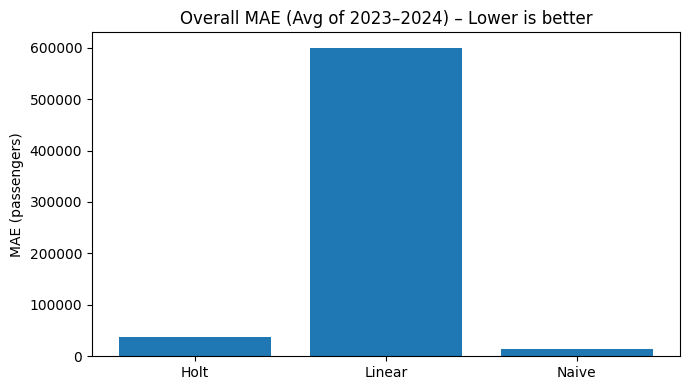

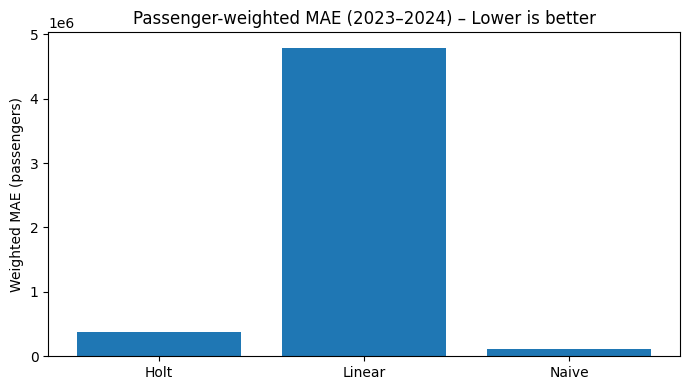

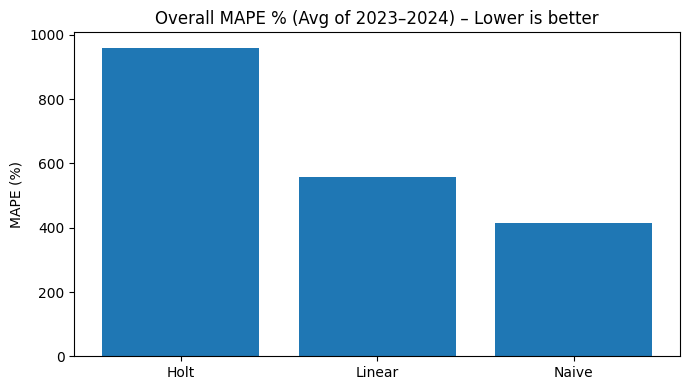

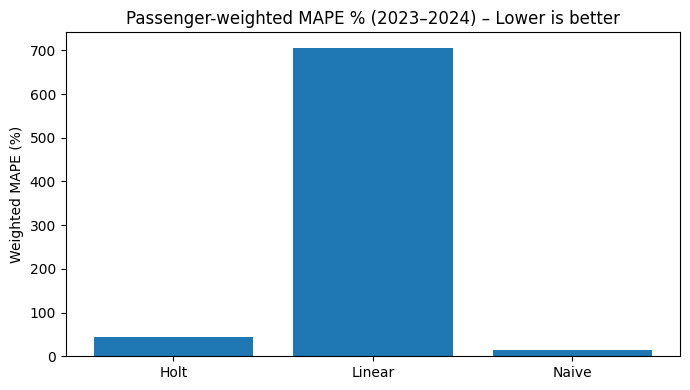

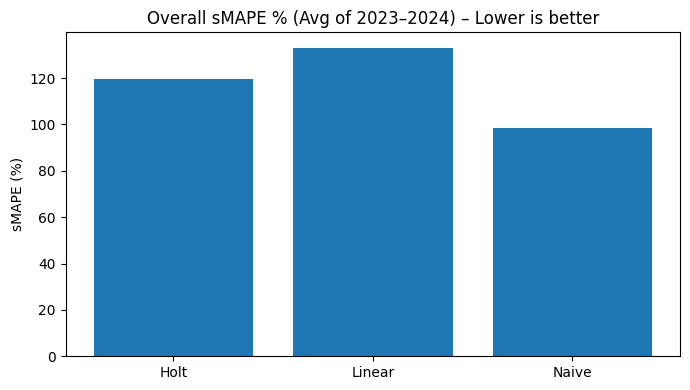

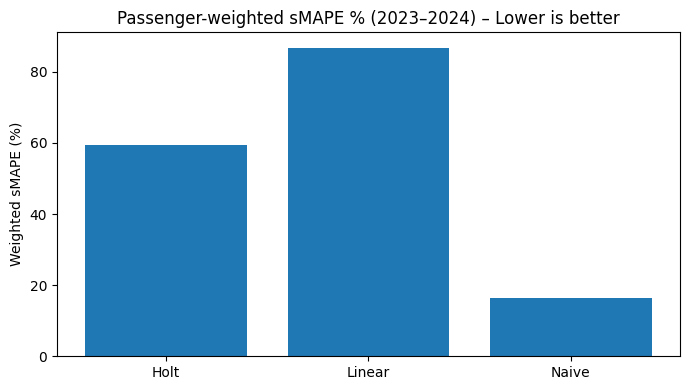

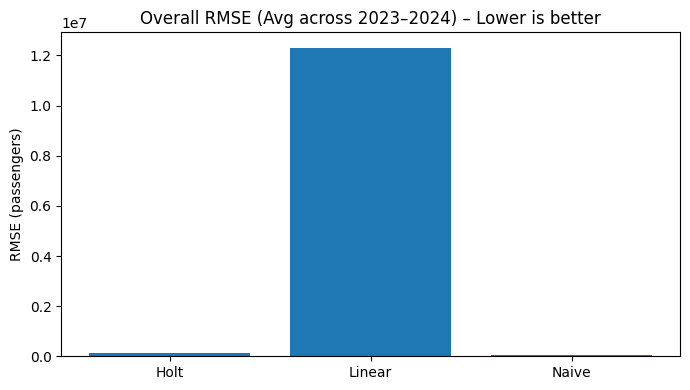

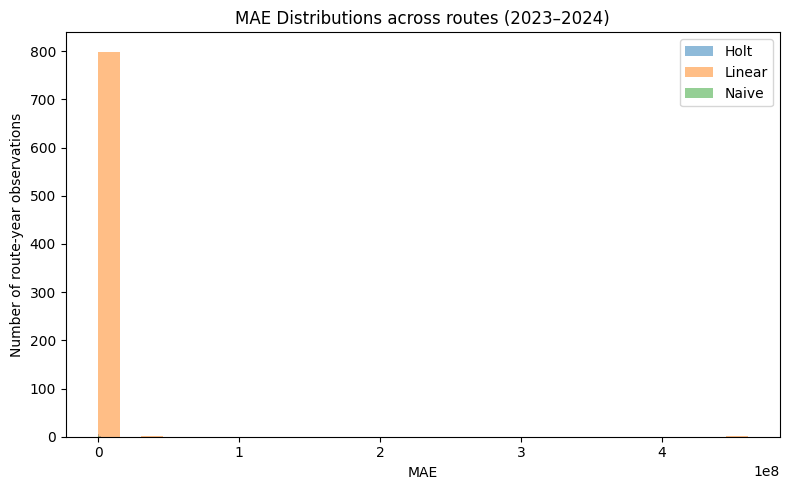

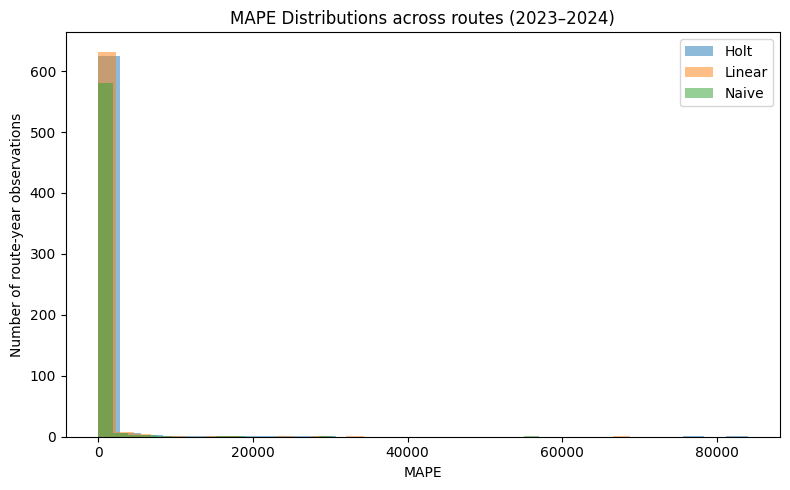

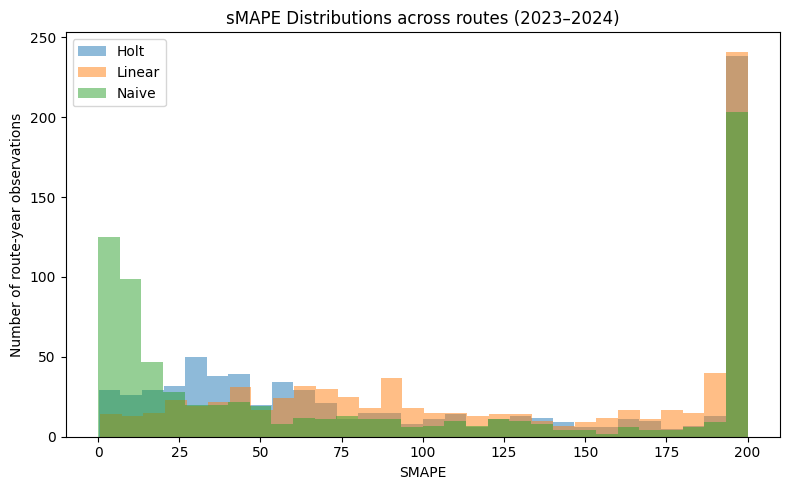

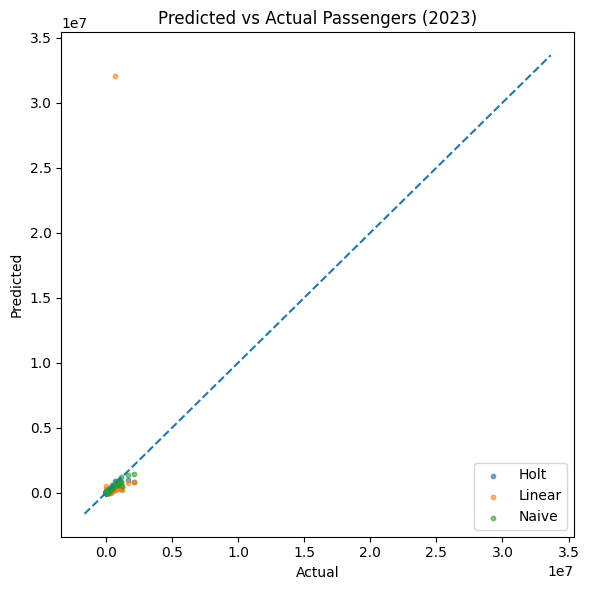

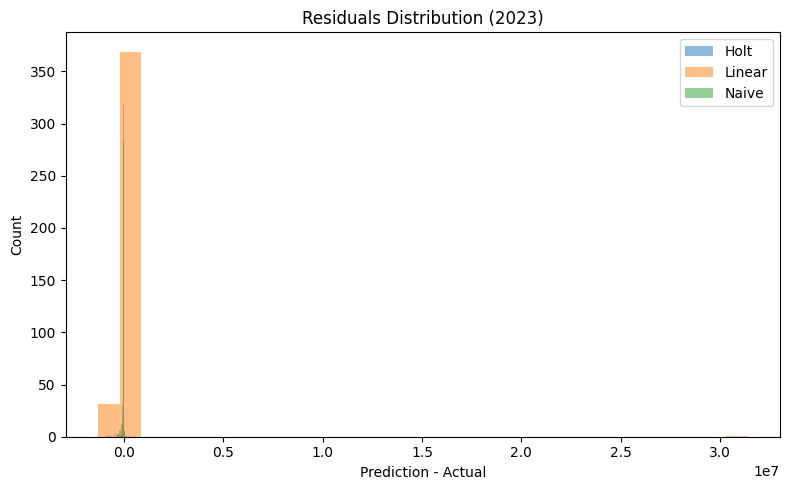

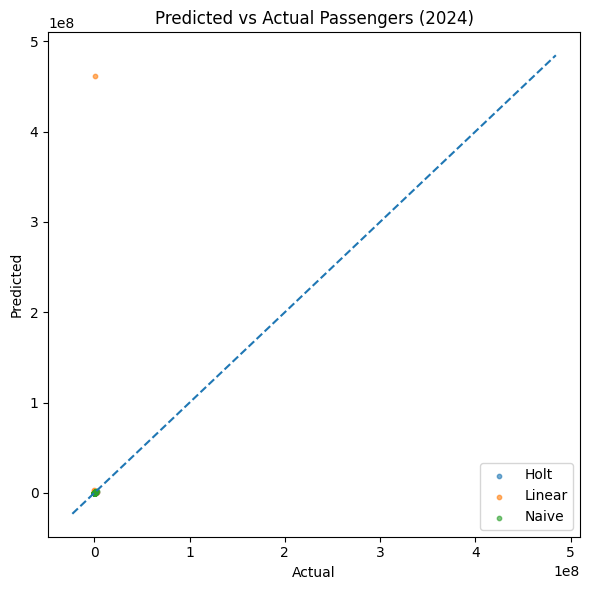

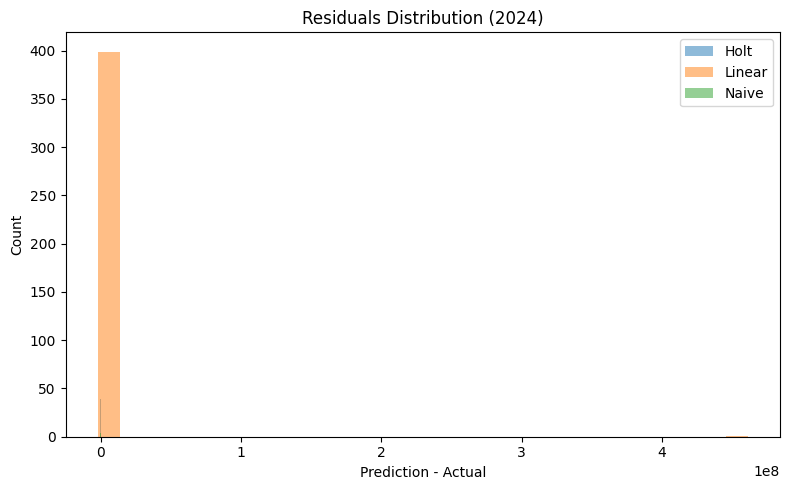

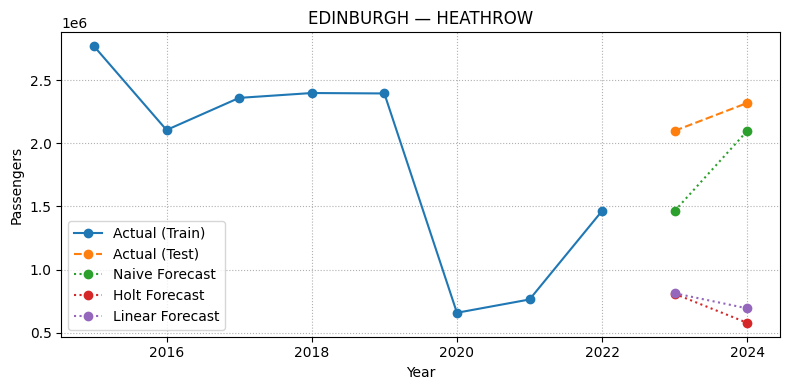

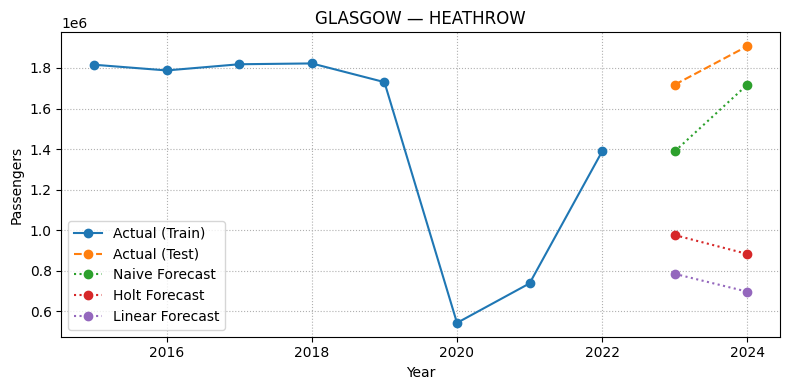

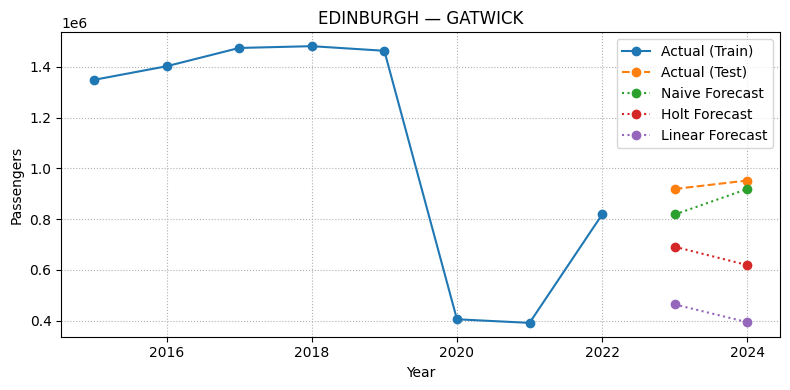

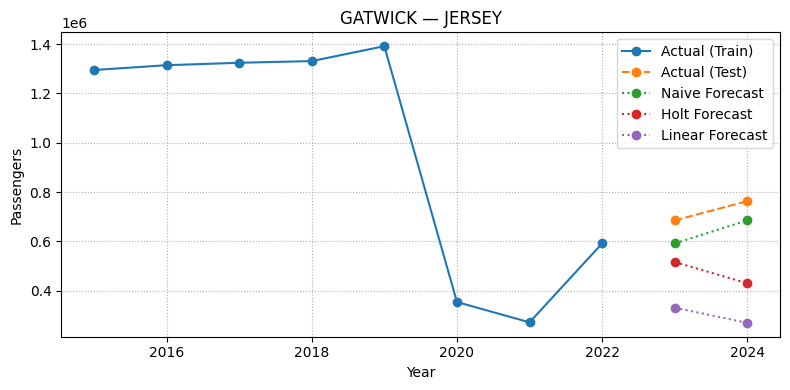

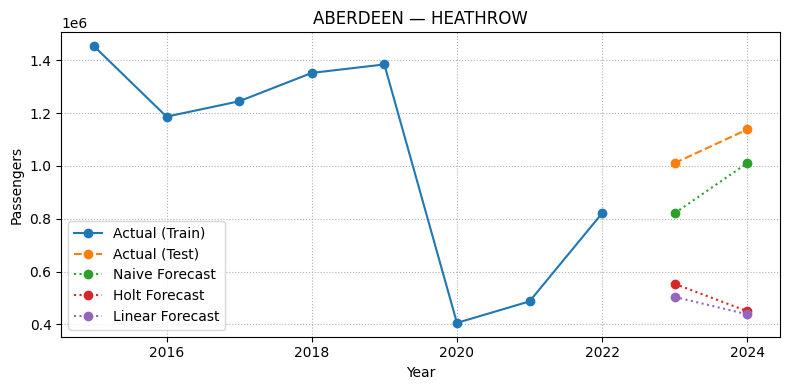

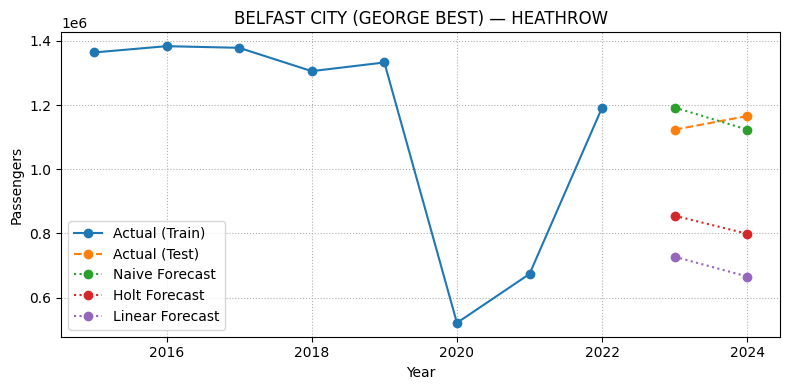

In [ ]:
# ---------------------------
# Main
# ---------------------------
def main():
    agg = load_and_aggregate(DATA_PATH)
    results, leaderboard, rmse_df = evaluate_models(agg)

    # ----- Leaderboards per metric -----
    # MAE
    bar_leaderboard(leaderboard, "overall_mae_avg",
                    "Overall MAE (Avg of 2023–2024) – Lower is better",
                    "lb_overall_mae.png", "MAE (passengers)")
    bar_leaderboard(leaderboard, "overall_weighted_mae",
                    "Passenger-weighted MAE (2023–2024) – Lower is better",
                    "lb_weighted_mae.png", "Weighted MAE (passengers)")

    # MAPE
    bar_leaderboard(leaderboard, "overall_mape_avg",
                    "Overall MAPE % (Avg of 2023–2024) – Lower is better",
                    "lb_overall_mape.png", "MAPE (%)")
    bar_leaderboard(leaderboard, "overall_weighted_mape",
                    "Passenger-weighted MAPE % (2023–2024) – Lower is better",
                    "lb_weighted_mape.png", "Weighted MAPE (%)")

    # sMAPE
    bar_leaderboard(leaderboard, "overall_smape_avg",
                    "Overall sMAPE % (Avg of 2023–2024) – Lower is better",
                    "lb_overall_smape.png", "sMAPE (%)")
    bar_leaderboard(leaderboard, "overall_weighted_smape",
                    "Passenger-weighted sMAPE % (2023–2024) – Lower is better",
                    "lb_weighted_smape.png", "Weighted sMAPE (%)")

    # RMSE (combined across 2023–24)
    bar_leaderboard(leaderboard, "overall_rmse_avg",
                    "Overall RMSE (Avg across 2023–2024) – Lower is better",
                    "lb_overall_rmse.png", "RMSE (passengers)")

    # ----- Error distributions -----
    hist_error_distribution(results, "mae",   "hist_mae.png",   "MAE Distributions across routes (2023–2024)")
    hist_error_distribution(results, "mape",  "hist_mape.png",  "MAPE Distributions across routes (2023–2024)")
    hist_error_distribution(results, "smape", "hist_smape.png", "sMAPE Distributions across routes (2023–2024)")

    # ----- Predicted vs Actual & Residuals -----
    for yr in TEST_YEARS:
        scatter_pred_vs_actual(results, yr)
        residual_plots(results, yr)

    # ----- Actual vs forecast lines for selected high-traffic routes -----
    # Pick top 6 routes by 2019 pax as examples
    top2019 = (agg[agg["year"]==2019]
               .sort_values("pax", ascending=False)
               .head(6)["route"].tolist())
    plot_actual_vs_forecast_lines(agg, results, top2019, suffix="top2019")

    print(f"[DONE] Saved CSVs to: {OUTDIR.resolve()}")
    print(f"[DONE] Saved figures to: {FIGDIR.resolve()}")

if __name__ == "__main__":
    main()